# Explained var by GPs

Compute amount of explained variation by GPs using top PCs as baseline. Ideally would compute over all samples from all studies (included in atlas and external) to make sure that variance between all possible conditions is included, but cant really as different preprocessing due to different technologies so expression across studies is not directly comparable - so do per study, except for the atlas, where we made sure that this is comparable.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.preprocessing import minmax_scale,maxabs_scale

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from scib import metrics as sm
from sklearn.linear_model import LinearRegression

In [2]:
path_gp='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/moransi/sfintegrated/'
path_rna='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/'
path_data=path_rna+'combined/'
path_save=path_gp+'explained_var/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [4]:
# orthologue information
orthologues=pd.read_table(path_genes+'orthologues_ORGmus_musculus_ORG2homo_sapiens_V103.tsv'
                         ).rename(
    {'Gene name':'gs_mm','Human gene name':'gs_hs',
     'Gene stable ID':'eid_mm','Human gene stable ID':'eid_hs'},axis=1)

In [5]:
# Load GPs
genes_hc=pd.read_table(path_gp+'gene_hc_t'+str(2.4)+'.tsv',sep='\t',index_col=0)
genes_hc['hc']=genes_hc['hc'].astype('category')

## Compute explained var
Compute explained var based on each GP or their combination in top PCs computed on expression data per dataset (using atlas as single dataset). In atlas also compute explained var by study. 

Use linear regresison to see how well individual PCs are explained (R2) and weight the R2 score by variance explained by each PC, summing explained var from all PCs to get final explained var.

Compare explained var of GPs to explained var of random gene groups of matched size. Compute random groups multiple times to get a proxy of random gene groups explained var distn.

In [6]:
# N PCs to use
NPC=50

Helper functions

In [7]:
def explained_pca_var(X_pca,covariates,pca_var,n_comps):
    """
    How much variance from PCs is explained.
    Adapted from scIB.
    :param X_pca: PCA embedding
    :param covariates: Design matrix for regression
    :param pca_var: Relative var explained by each PC
    :param n_comps: N PC components in the embedding
    """
    r2 = []
    for i in range(n_comps):
        pc = X_pca[:, [i]]
        lm = LinearRegression()
        lm.fit(covariates, pc)
        r2_score = np.maximum(0, lm.score(covariates, pc))
        r2.append(r2_score)
    Var = pca_var / sum(pca_var) 
    R2Var = sum(r2 * Var) 
    return R2Var

In [8]:
def explaied_var_helper(gp_study:list,adata,gene_groups_collection:dict,study_cov:np.array):
    """
    Helper to calculate explained var by GPs or studies or both (concatenates both as predictor)
    Also computes for individual GPs (without study, not computed if study is True)
    :param gp_study: list of tuples giving 
    (GP name or None (if not used), True/False for using study)
    :param adata: Pp adata
    :param gene_groups_collection: Dict with keys GP type names and values GP dicts with
    keys being gp names and values gene lists matching adata var names:
    {gp_type:{gp_name:genes,...}}
    :param study_cov: Array of study embedding or None if not used
    """
    # Score for GPs (true or random), study, and true GP+study
    # In each GP set compute explained var over all GPs
    explained_var=[]
    for gp,study in gp_study:
        print('GP and study:',gp,study)
        cov=[]
        # Use GP scores for prediction
        scores_gp={}
        if gp is not None:
            gene_groups=gene_groups_collection[gp]
            for gp_component,genes in gene_groups.items():
                scores_gp[gp_component]=sc.tl.score_genes(
                    adata, gene_list=genes, score_name='score', 
                    use_raw=False,copy=True,random_state=0
                    ).obs['score'].values
            cov.append(np.array(list(scores_gp.values())).T)
        # Use study cov as prediction
        if study:
            cov.append(study_cov) # Not full rank but ok?
        cov=np.concatenate(cov,axis=1)
        print('cov shape:',cov.shape)
        explained_var.append({
            'GPs':gp,'study':study,
            'explained_var_ratio':explained_pca_var(X_pca=adata.obsm['X_pca'],
                          covariates=cov,
                          pca_var=adata.uns['pca']['variance'],
                          n_comps=NPC)})
        # Compute also var exmplained by each GP if present
        if not study:
            for gp_component,score in scores_gp.items():
                explained_var.append({
                    'GPs':gp+'_GPcomponent'+str(gp_component),'study':False,
                    'explained_var_ratio':explained_pca_var(X_pca=adata.obsm['X_pca'],
                              covariates=np.array(score).reshape(-1,1),
                              pca_var=adata.uns['pca']['variance'],
                              n_comps=NPC)})
        del cov
        del scores_gp
    explained_var=pd.DataFrame(explained_var)
    return explained_var

Store dataset metadata and size infro from all datasets for below plots

In [41]:
# Store dataset info
dataset_info=[]

Compute explained var for all datasets individually

### Atlas per study
This is done as sanity check to make sure that GPs look like expected on individual studies within atlas.

In [32]:
dataset='mouseAtlas'
adata_full=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',backed='r')

In [33]:
studies=[s for s in adata_full.obs.study.unique() if s!='embryo']

In [11]:
for study in studies:
    print(study)
    adata=adata_full[adata_full.obs.study==study,:].copy()
    print(adata.shape)
    
    # PP
    
    # Remove lowly expressed genes
    sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
    print('After lowly expr filtering:',adata.shape)
    # Compute HVG and PCA
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
    sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)
    
    # GP selection
    
    # Subset GPs to only genes in data
    genes_hc_sub=genes_hc.loc[[g for g in adata.var_names if g in genes_hc.index],:]
    print('N GP genes:',genes_hc_sub.shape[0])
    # Make sizes of GPs for random creation
    # Splits for np split
    splits=[]
    n_curr=0
    # MAke sure this is ordered as gps
    for n in genes_hc_sub['hc'].value_counts(sort=False).values:
        splits.append(n_curr+n)
        n_curr+=n
    # Do not use last one as automatically createcd
    splits=splits[:-1]   
    
    # Gene groups - GP and random
    gene_groups_collection={}
    # Add true GPs
    gene_groups_collection['GPs']={hc:list(g) 
                                   for hc,g in genes_hc_sub.groupby('hc').groups.items()}
    # Add random gene groups of GP sizes
    np.random.seed(0)
    for i in range(10):
        # Random idx groups of GP sizes
        random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                                 )[:genes_hc_sub.shape[0]],splits)
        # Map idx to genes
        gene_groups_collection['GPs_random'+str(i)]={
            genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
            for gp_idx,idxs in enumerate(random_indices)}
        
        
    # Explained var
    explained_var=explaied_var_helper(
        gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
        adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
    display(explained_var)
    explained_var.to_csv(path_save+dataset+'-study_'+study+'.tsv',sep='\t',index=False)

Fltp_2y
(14317, 30672)
After lowly expr filtering: (14317, 12702)
N GP genes: 1602
GP and study: GPs False
cov shape: (14317, 27)
GP and study: GPs_random0 False
cov shape: (14317, 27)
GP and study: GPs_random1 False
cov shape: (14317, 27)
GP and study: GPs_random3 False
cov shape: (14317, 27)
GP and study: GPs_random4 False
cov shape: (14317, 27)
GP and study: GPs_random5 False
cov shape: (14317, 27)
GP and study: GPs_random6 False
cov shape: (14317, 27)
GP and study: GPs_random7 False
cov shape: (14317, 27)
GP and study: GPs_random8 False
cov shape: (14317, 27)
GP and study: GPs_random9 False
cov shape: (14317, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.461627
1,GPs_GPcomponent1,False,0.026018
2,GPs_GPcomponent2,False,0.066029
3,GPs_GPcomponent3,False,0.022747
4,GPs_GPcomponent4,False,0.041269
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.005504
304,GPs_random9_GPcomponent24,False,0.002187
305,GPs_random9_GPcomponent25,False,0.031352
306,GPs_random9_GPcomponent26,False,0.004390


Fltp_adult
(13738, 30672)
After lowly expr filtering: (13738, 12606)
N GP genes: 1592
GP and study: GPs False
cov shape: (13738, 27)
GP and study: GPs_random0 False
cov shape: (13738, 27)
GP and study: GPs_random1 False
cov shape: (13738, 27)
GP and study: GPs_random2 False
cov shape: (13738, 27)
GP and study: GPs_random3 False
cov shape: (13738, 27)
GP and study: GPs_random4 False
cov shape: (13738, 27)
GP and study: GPs_random5 False
cov shape: (13738, 27)
GP and study: GPs_random6 False
cov shape: (13738, 27)
GP and study: GPs_random7 False
cov shape: (13738, 27)
GP and study: GPs_random8 False
cov shape: (13738, 27)
GP and study: GPs_random9 False
cov shape: (13738, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.360445
1,GPs_GPcomponent1,False,0.012645
2,GPs_GPcomponent2,False,0.027749
3,GPs_GPcomponent3,False,0.021310
4,GPs_GPcomponent4,False,0.032069
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.000923
304,GPs_random9_GPcomponent24,False,0.001671
305,GPs_random9_GPcomponent25,False,0.006344
306,GPs_random9_GPcomponent26,False,0.001796


Fltp_P16
(7410, 30672)
After lowly expr filtering: (7410, 12084)
N GP genes: 1568
GP and study: GPs False
cov shape: (7410, 27)
GP and study: GPs_random0 False
cov shape: (7410, 27)
GP and study: GPs_random1 False
cov shape: (7410, 27)
GP and study: GPs_random2 False
cov shape: (7410, 27)
GP and study: GPs_random3 False
cov shape: (7410, 27)
GP and study: GPs_random4 False
cov shape: (7410, 27)
GP and study: GPs_random5 False
cov shape: (7410, 27)
GP and study: GPs_random6 False
cov shape: (7410, 27)
GP and study: GPs_random7 False
cov shape: (7410, 27)
GP and study: GPs_random8 False
cov shape: (7410, 27)
GP and study: GPs_random9 False
cov shape: (7410, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.362304
1,GPs_GPcomponent1,False,0.011038
2,GPs_GPcomponent2,False,0.015623
3,GPs_GPcomponent3,False,0.027987
4,GPs_GPcomponent4,False,0.020033
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.003864
304,GPs_random9_GPcomponent24,False,0.001802
305,GPs_random9_GPcomponent25,False,0.003302
306,GPs_random9_GPcomponent26,False,0.002046


NOD
(1534, 30672)
After lowly expr filtering: (1534, 12591)
N GP genes: 1595
GP and study: GPs False
cov shape: (1534, 27)
GP and study: GPs_random0 False
cov shape: (1534, 27)
GP and study: GPs_random1 False
cov shape: (1534, 27)
GP and study: GPs_random2 False
cov shape: (1534, 27)
GP and study: GPs_random3 False
cov shape: (1534, 27)
GP and study: GPs_random4 False
cov shape: (1534, 27)
GP and study: GPs_random5 False
cov shape: (1534, 27)
GP and study: GPs_random6 False
cov shape: (1534, 27)
GP and study: GPs_random7 False
cov shape: (1534, 27)
GP and study: GPs_random8 False
cov shape: (1534, 27)
GP and study: GPs_random9 False
cov shape: (1534, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.451337
1,GPs_GPcomponent1,False,0.030001
2,GPs_GPcomponent2,False,0.043711
3,GPs_GPcomponent3,False,0.029668
4,GPs_GPcomponent4,False,0.065832
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.003627
304,GPs_random9_GPcomponent24,False,0.004338
305,GPs_random9_GPcomponent25,False,0.002005
306,GPs_random9_GPcomponent26,False,0.002071


NOD_elimination
(3739, 30672)
After lowly expr filtering: (3739, 12796)
N GP genes: 1624
GP and study: GPs False
cov shape: (3739, 27)
GP and study: GPs_random0 False
cov shape: (3739, 27)
GP and study: GPs_random1 False
cov shape: (3739, 27)
GP and study: GPs_random2 False
cov shape: (3739, 27)
GP and study: GPs_random3 False
cov shape: (3739, 27)
GP and study: GPs_random4 False
cov shape: (3739, 27)
GP and study: GPs_random5 False
cov shape: (3739, 27)
GP and study: GPs_random6 False
cov shape: (3739, 27)
GP and study: GPs_random7 False
cov shape: (3739, 27)
GP and study: GPs_random8 False
cov shape: (3739, 27)
GP and study: GPs_random9 False
cov shape: (3739, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.513450
1,GPs_GPcomponent1,False,0.140492
2,GPs_GPcomponent2,False,0.048862
3,GPs_GPcomponent3,False,0.025729
4,GPs_GPcomponent4,False,0.079492
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.002197
304,GPs_random9_GPcomponent24,False,0.008268
305,GPs_random9_GPcomponent25,False,0.007951
306,GPs_random9_GPcomponent26,False,0.000862


spikein_drug
(15059, 30672)
After lowly expr filtering: (15059, 12149)
N GP genes: 1546
GP and study: GPs False
cov shape: (15059, 27)
GP and study: GPs_random0 False
cov shape: (15059, 27)
GP and study: GPs_random1 False
cov shape: (15059, 27)
GP and study: GPs_random2 False
cov shape: (15059, 27)
GP and study: GPs_random3 False
cov shape: (15059, 27)
GP and study: GPs_random4 False
cov shape: (15059, 27)
GP and study: GPs_random5 False
cov shape: (15059, 27)
GP and study: GPs_random6 False
cov shape: (15059, 27)
GP and study: GPs_random7 False
cov shape: (15059, 27)
GP and study: GPs_random8 False
cov shape: (15059, 27)
GP and study: GPs_random9 False
cov shape: (15059, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.430486
1,GPs_GPcomponent1,False,0.099568
2,GPs_GPcomponent2,False,0.034679
3,GPs_GPcomponent3,False,0.016062
4,GPs_GPcomponent4,False,0.063577
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.004405
304,GPs_random9_GPcomponent24,False,0.005066
305,GPs_random9_GPcomponent25,False,0.001549
306,GPs_random9_GPcomponent26,False,0.002217


VSG
(31983, 30672)
After lowly expr filtering: (31983, 13005)
N GP genes: 1615
GP and study: GPs False
cov shape: (31983, 27)
GP and study: GPs_random0 False
cov shape: (31983, 27)
GP and study: GPs_random1 False
cov shape: (31983, 27)
GP and study: GPs_random2 False
cov shape: (31983, 27)
GP and study: GPs_random3 False
cov shape: (31983, 27)
GP and study: GPs_random4 False
cov shape: (31983, 27)
GP and study: GPs_random5 False
cov shape: (31983, 27)
GP and study: GPs_random6 False
cov shape: (31983, 27)
GP and study: GPs_random7 False
cov shape: (31983, 27)
GP and study: GPs_random8 False
cov shape: (31983, 27)
GP and study: GPs_random9 False
cov shape: (31983, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.552104
1,GPs_GPcomponent1,False,0.022030
2,GPs_GPcomponent2,False,0.161155
3,GPs_GPcomponent3,False,0.323840
4,GPs_GPcomponent4,False,0.243291
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.001767
304,GPs_random9_GPcomponent24,False,0.000791
305,GPs_random9_GPcomponent25,False,0.006882
306,GPs_random9_GPcomponent26,False,0.006206


STZ
(14329, 30672)
After lowly expr filtering: (14329, 12336)
N GP genes: 1583
GP and study: GPs False
cov shape: (14329, 27)
GP and study: GPs_random0 False
cov shape: (14329, 27)
GP and study: GPs_random1 False
cov shape: (14329, 27)
GP and study: GPs_random2 False
cov shape: (14329, 27)
GP and study: GPs_random3 False
cov shape: (14329, 27)
GP and study: GPs_random4 False
cov shape: (14329, 27)
GP and study: GPs_random5 False
cov shape: (14329, 27)
GP and study: GPs_random6 False
cov shape: (14329, 27)
GP and study: GPs_random7 False
cov shape: (14329, 27)
GP and study: GPs_random8 False
cov shape: (14329, 27)
GP and study: GPs_random9 False
cov shape: (14329, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.521043
1,GPs_GPcomponent1,False,0.017231
2,GPs_GPcomponent2,False,0.077427
3,GPs_GPcomponent3,False,0.251007
4,GPs_GPcomponent4,False,0.145336
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.003769
304,GPs_random9_GPcomponent24,False,0.032879
305,GPs_random9_GPcomponent25,False,0.006366
306,GPs_random9_GPcomponent26,False,0.002255


In [ ]:
del adata_full
del adata

#### Analyse

In [51]:
# Load and parse all results into shared table
explained_var_all=[]
for study in studies:
    explained_var=pd.read_table(path_save+dataset+'-study_'+study+'.tsv')
    explained_var['component']=explained_var['GPs'].fillna('NA').apply(
        lambda x: np.nan if x =='NA' else 
        ('GPs' if 'component' not in x else x.split('component')[1]))
    explained_var['random']=explained_var['GPs'].str.contains('random')
    explained_var['dataset']=study
    explained_var_all.append(explained_var)
explained_var_all=pd.concat(explained_var_all)    

Explained var in each study by all GPs

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


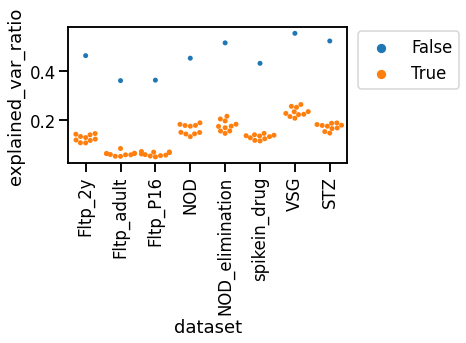

In [52]:
# Plot explained var vs random explained var for each dataset
rcParams['figure.figsize']=(5,2.5)
sb.swarmplot(x='dataset',y='explained_var_ratio',hue='random',s=5,
            data=explained_var_all.query('~GPs.str.contains("component")',engine='python'))

a=plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.01,1.03))

Explained var in each study by individual GPs. How much var is explained and how many stds is this from mean on random gene groups.

In [54]:
# Get explained var for each component in each dataset and compare to random var
explained_component=[]
for (dataset, component),data in explained_var_all.query(
    'study==False & component!="GPs"').groupby(['dataset','component']):
    explained=data[~data.random.astype(bool)]['explained_var_ratio'].values[0]
    explained_random=data[data.random.astype(bool)]['explained_var_ratio']
    explained_n_std=(explained-explained_random.mean())/explained_random.std()
    explained_component.append(
        {'dataset':dataset,'component':component,
        'explained_var':explained,'explained_var_n_std':explained_n_std})
explained_component=pd.DataFrame(explained_component)  
# Sort components for plotting
explained_component['component']=pd.Categorical(
    explained_component['component'],
    [str(c) for c in sorted(explained_component['component'].astype(int).unique())],
    True)
explained_component['dataset']=pd.Categorical(
    explained_component['dataset'],sorted(explained_component['dataset'].unique()),True)

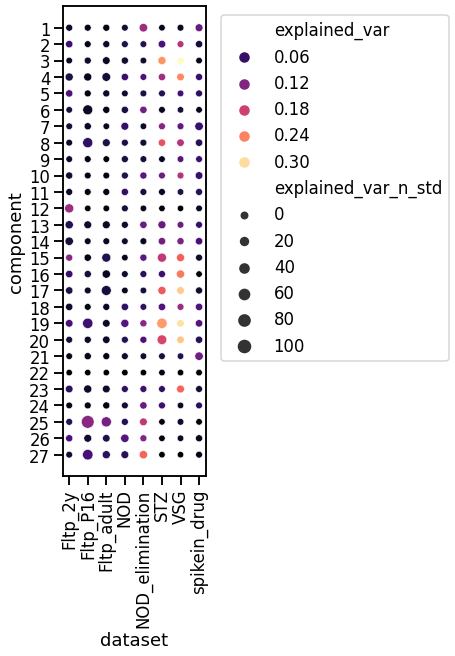

In [55]:
# Explained var by component
rcParams['figure.figsize']=(explained_component.dataset.nunique()*0.32,
                            explained_component.component.nunique()*0.32)
sb.scatterplot(x='dataset',y='component',hue='explained_var',size='explained_var_n_std',
               data=explained_component,palette='magma')
plt.legend(bbox_to_anchor=(1.05, 1))
a=plt.xticks(rotation=90)

Contribution of GP components for each dataset, scaled (maxabs) across GPs

<AxesSubplot:xlabel='dataset', ylabel='component'>

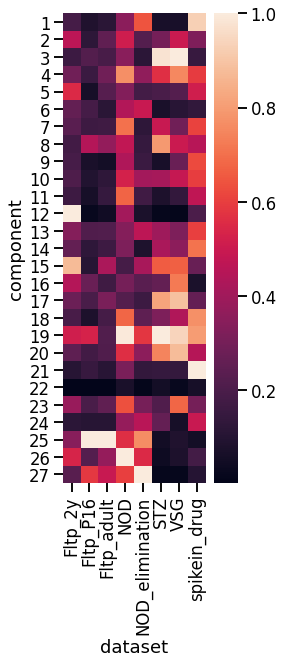

In [56]:
# Scaling contibution across components
figsize=(explained_component.dataset.nunique()*0.4,
         explained_component.component.nunique()*0.32)
rcParams['figure.figsize']=figsize
scaled=pd.crosstab(columns=explained_component['dataset'],index=explained_component['component'],
            values=explained_component['explained_var'],aggfunc='mean')
scaled=pd.DataFrame(maxabs_scale(scaled),index=scaled.index,columns=scaled.columns)
sb.heatmap(scaled,xticklabels=True,yticklabels=True)

C: Expected GPs are most explanatory in studies of atlas. E.g. GPs connected to diabetes for datasets containing healthy and diabetic samples; GPs separating aged sexes in 2y datasets, ...

### Atlas - using as single study

In [43]:
dataset='mouseAtlas'
info={}
info['dataset']=dataset
info['organism']='mouse'
info['technology']='10X'

In [44]:
adata=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
info['n_cells']=adata.shape[0]
adata.shape

(102143, 30672)

In [45]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

(102143, 12890)


In [46]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [47]:
# Subset GPs to only genes in data
genes_hc_sub=genes_hc.loc[[g for g in adata.var_names if g in genes_hc.index],:]
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# MAke sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1659


In [48]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [49]:
# Study dimmies
study_cov = pd.get_dummies(adata.obs['study'])

In [54]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()]+[(None,True),('GPs',True)],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=study_cov)
display(explained_var)

GP and study: GPs False
cov shape: (102143, 27)
GP and study: GPs_random0 False
cov shape: (102143, 27)
GP and study: GPs_random1 False
cov shape: (102143, 27)
GP and study: GPs_random2 False
cov shape: (102143, 27)
GP and study: GPs_random3 False
cov shape: (102143, 27)
GP and study: GPs_random4 False
cov shape: (102143, 27)
GP and study: GPs_random5 False
cov shape: (102143, 27)
GP and study: GPs_random6 False
cov shape: (102143, 27)
GP and study: GPs_random7 False
cov shape: (102143, 27)
GP and study: GPs_random8 False
cov shape: (102143, 27)
GP and study: GPs_random9 False
cov shape: (102143, 27)
GP and study: None True
cov shape: (102143, 9)
GP and study: GPs True
cov shape: (102143, 36)


,GPs,study,explained_var_ratio
0,GPs,False,0.680508
1,GPs_GPcomponent1,False,0.106980
2,GPs_GPcomponent2,False,0.165289
3,GPs_GPcomponent3,False,0.196279
4,GPs_GPcomponent4,False,0.149756
...,...,...,...
305,GPs_random9_GPcomponent25,False,0.009393
306,GPs_random9_GPcomponent26,False,0.012658
307,GPs_random9_GPcomponent27,False,0.005016
308,None,True,0.459854


In [55]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [56]:
info

{'dataset': 'mouseAtlas',
 'organism': 'mouse',
 'technology': '10X',
 'n_cells': 102143,
 'n_gp_genes': 1659}

In [57]:
dataset_info.append(info)

### GSE137909

In [69]:
dataset='GSE137909'
info={}
info['dataset']=dataset
info['organism']='mouse'
info['technology']='STRT-seq'

In [70]:
ddir=dataset+'/GEO/'
adata=sc.read(path_rna+ddir+'adata.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(1005, 40824)

In [71]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(1005, 14863)


In [72]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [73]:
adata.var_names[:3]

Index(['ENSMUSG00000000001', 'ENSMUSG00000000028', 'ENSMUSG00000000037'], dtype='object', name='ID')

In [74]:
# Subset GPs to only genes in data
genes_hc_sub=genes_hc.loc[[g for g in adata.var_names if g in genes_hc.index],:]
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1570


In [75]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [76]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (1005, 27)
GP and study: GPs_random0 False
cov shape: (1005, 27)
GP and study: GPs_random1 False
cov shape: (1005, 27)
GP and study: GPs_random2 False
cov shape: (1005, 27)
GP and study: GPs_random3 False
cov shape: (1005, 27)
GP and study: GPs_random4 False
cov shape: (1005, 27)
GP and study: GPs_random5 False
cov shape: (1005, 27)
GP and study: GPs_random6 False
cov shape: (1005, 27)
GP and study: GPs_random7 False
cov shape: (1005, 27)
GP and study: GPs_random8 False
cov shape: (1005, 27)
GP and study: GPs_random9 False
cov shape: (1005, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.477245
1,GPs_GPcomponent1,False,0.045073
2,GPs_GPcomponent2,False,0.042624
3,GPs_GPcomponent3,False,0.129843
4,GPs_GPcomponent4,False,0.057197
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.011471
304,GPs_random9_GPcomponent24,False,0.013194
305,GPs_random9_GPcomponent25,False,0.018215
306,GPs_random9_GPcomponent26,False,0.012895


In [77]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [78]:
info

{'dataset': 'GSE137909',
 'organism': 'mouse',
 'technology': 'STRT-seq',
 'n_cells': 1005,
 'n_gp_genes': 1570}

In [79]:
dataset_info.append(info)

### GSE83146

In [80]:
dataset='GSE83146'
info={}
info['dataset']=dataset
info['organism']='mouse'
info['technology']='FluidigmC1_SMARTer'

In [81]:
ddir=dataset+'/GEO/'
adata=sc.read(path_rna+ddir+'adata.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(207, 44448)

In [82]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(207, 21232)


In [83]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [84]:
adata.var_names[:3]

Index(['11302', '11303', '11304'], dtype='object', name='gene.id')

In [87]:
# Subset GPs to only genes in data
# Map to gene ids in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in adata.var.query('EID==@eid').index:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1554


In [88]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [89]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (207, 27)
GP and study: GPs_random0 False
cov shape: (207, 27)
GP and study: GPs_random1 False
cov shape: (207, 27)
GP and study: GPs_random2 False
cov shape: (207, 27)
GP and study: GPs_random3 False
cov shape: (207, 27)
GP and study: GPs_random4 False
cov shape: (207, 27)
GP and study: GPs_random5 False
cov shape: (207, 27)
GP and study: GPs_random6 False
cov shape: (207, 27)
GP and study: GPs_random7 False
cov shape: (207, 27)
GP and study: GPs_random8 False
cov shape: (207, 27)
GP and study: GPs_random9 False
cov shape: (207, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.315095
1,GPs_GPcomponent1,False,0.025416
2,GPs_GPcomponent2,False,0.072480
3,GPs_GPcomponent3,False,0.044339
4,GPs_GPcomponent4,False,0.094984
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.004928
304,GPs_random9_GPcomponent24,False,0.009009
305,GPs_random9_GPcomponent25,False,0.005308
306,GPs_random9_GPcomponent26,False,0.008047


In [90]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [91]:
info

{'dataset': 'GSE83146',
 'organism': 'mouse',
 'technology': 'FluidigmC1_SMARTer',
 'n_cells': 207,
 'n_gp_genes': 1554}

In [92]:
dataset_info.append(info)

### GSE83139

In [93]:
dataset='GSE83139'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='Fluidigm_SMART-seq'

In [94]:
ddir=dataset+'/GEO/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(111, 19950)

In [95]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(111, 19950)


In [96]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [97]:
adata.var.iloc[:1]

,n_cells,highly_variable,means,dispersions,dispersions_norm
gene,,,,,
GCG,111,False,5.708737,0.435312,-0.721017


In [98]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for gid in orthologues.query('eid_mm==@eid').gs_hs 
                if gid in adata.var_names]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1423


In [99]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [100]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (111, 27)
GP and study: GPs_random0 False
cov shape: (111, 27)
GP and study: GPs_random1 False
cov shape: (111, 27)
GP and study: GPs_random2 False
cov shape: (111, 27)
GP and study: GPs_random3 False
cov shape: (111, 27)
GP and study: GPs_random4 False
cov shape: (111, 27)
GP and study: GPs_random5 False
cov shape: (111, 27)
GP and study: GPs_random6 False
cov shape: (111, 27)
GP and study: GPs_random7 False
cov shape: (111, 27)
GP and study: GPs_random8 False
cov shape: (111, 27)
GP and study: GPs_random9 False
cov shape: (111, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.350042
1,GPs_GPcomponent1,False,0.027861
2,GPs_GPcomponent2,False,0.062309
3,GPs_GPcomponent3,False,0.022105
4,GPs_GPcomponent4,False,0.060681
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.008890
304,GPs_random9_GPcomponent24,False,0.010682
305,GPs_random9_GPcomponent25,False,0.025016
306,GPs_random9_GPcomponent26,False,0.017071


In [101]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [102]:
info

{'dataset': 'GSE83139',
 'organism': 'human',
 'technology': 'Fluidigm_SMART-seq',
 'n_cells': 111,
 'n_gp_genes': 1423}

In [103]:
dataset_info.append(info)

### GSE154126

In [104]:
dataset='GSE154126'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='SMART-seq'

In [105]:
ddir=dataset+'/GEO/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(182, 21152)

In [106]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(182, 16724)


In [107]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [108]:
adata.var.iloc[:1]

,n_cells,highly_variable,means,dispersions,dispersions_norm
gene|cell_id,,,,,
GCG,182,False,5.877211,0.2398,-0.654617


In [109]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for gid in orthologues.query('eid_mm==@eid').gs_hs 
                if gid in adata.var_names]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1360


In [110]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [111]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (182, 27)
GP and study: GPs_random0 False
cov shape: (182, 27)
GP and study: GPs_random1 False
cov shape: (182, 27)
GP and study: GPs_random2 False
cov shape: (182, 27)
GP and study: GPs_random3 False
cov shape: (182, 27)
GP and study: GPs_random4 False
cov shape: (182, 27)
GP and study: GPs_random5 False
cov shape: (182, 27)
GP and study: GPs_random6 False
cov shape: (182, 27)
GP and study: GPs_random7 False
cov shape: (182, 27)
GP and study: GPs_random8 False
cov shape: (182, 27)
GP and study: GPs_random9 False
cov shape: (182, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.265033
1,GPs_GPcomponent1,False,0.012218
2,GPs_GPcomponent2,False,0.029607
3,GPs_GPcomponent3,False,0.018325
4,GPs_GPcomponent4,False,0.043016
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.011540
304,GPs_random9_GPcomponent24,False,0.009755
305,GPs_random9_GPcomponent25,False,0.007137
306,GPs_random9_GPcomponent26,False,0.017017


In [112]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [113]:
info

{'dataset': 'GSE154126',
 'organism': 'human',
 'technology': 'SMART-seq',
 'n_cells': 182,
 'n_gp_genes': 1360}

In [114]:
dataset_info.append(info)

### GSE101207

In [115]:
dataset='GSE101207'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='Drop-seq'

In [116]:
ddir=dataset+'/GEO/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(9958, 20485)

In [117]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(9958, 8305)


In [118]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [119]:
adata.var.iloc[:1]

,n_cells,highly_variable,means,dispersions,dispersions_norm
GENE,,,,,
A1BG,546,False,0.002099,0.107476,-0.643016


In [120]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for gid in orthologues.query('eid_mm==@eid').gs_hs 
                if gid in adata.var_names]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1029


In [121]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [122]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (9958, 27)
GP and study: GPs_random0 False
cov shape: (9958, 27)
GP and study: GPs_random1 False
cov shape: (9958, 27)
GP and study: GPs_random2 False
cov shape: (9958, 27)
GP and study: GPs_random3 False
cov shape: (9958, 27)
GP and study: GPs_random4 False
cov shape: (9958, 27)
GP and study: GPs_random5 False
cov shape: (9958, 27)
GP and study: GPs_random6 False
cov shape: (9958, 27)
GP and study: GPs_random7 False
cov shape: (9958, 27)
GP and study: GPs_random8 False
cov shape: (9958, 27)
GP and study: GPs_random9 False
cov shape: (9958, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.514281
1,GPs_GPcomponent1,False,0.080064
2,GPs_GPcomponent2,False,0.015617
3,GPs_GPcomponent3,False,0.014927
4,GPs_GPcomponent4,False,0.099223
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.015270
304,GPs_random9_GPcomponent24,False,0.002493
305,GPs_random9_GPcomponent25,False,0.000446
306,GPs_random9_GPcomponent26,False,0.000254


In [123]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [124]:
info

{'dataset': 'GSE101207',
 'organism': 'human',
 'technology': 'Drop-seq',
 'n_cells': 9958,
 'n_gp_genes': 1029}

In [125]:
dataset_info.append(info)

### GSE124742 and GSE164875 - patch 

In [126]:
dataset='GSE124742_GSE164875-patch'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='SMART-seq2'

In [127]:
ddir='/GSE124742_GSE164875/GEO/patch/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(496, 45305)

In [128]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(496, 23471)


In [129]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [130]:
adata.var.iloc[:1]

,n_cells,highly_variable,means,dispersions,dispersions_norm
Cell ID,,,,,
TSPAN6,38,True,0.256759,3.465943,1.593101


In [131]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for gid in orthologues.query('eid_mm==@eid').gs_hs 
                if gid in adata.var_names]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1461


In [132]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [133]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (496, 27)
GP and study: GPs_random0 False
cov shape: (496, 27)
GP and study: GPs_random1 False
cov shape: (496, 27)
GP and study: GPs_random2 False
cov shape: (496, 27)
GP and study: GPs_random3 False
cov shape: (496, 27)
GP and study: GPs_random4 False
cov shape: (496, 27)
GP and study: GPs_random5 False
cov shape: (496, 27)
GP and study: GPs_random6 False
cov shape: (496, 27)
GP and study: GPs_random7 False
cov shape: (496, 27)
GP and study: GPs_random8 False
cov shape: (496, 27)
GP and study: GPs_random9 False
cov shape: (496, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.295505
1,GPs_GPcomponent1,False,0.017391
2,GPs_GPcomponent2,False,0.065206
3,GPs_GPcomponent3,False,0.085647
4,GPs_GPcomponent4,False,0.083250
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.006969
304,GPs_random9_GPcomponent24,False,0.006905
305,GPs_random9_GPcomponent25,False,0.009592
306,GPs_random9_GPcomponent26,False,0.009811


In [134]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [135]:
info

{'dataset': 'GSE124742_GSE164875-patch',
 'organism': 'human',
 'technology': 'SMART-seq2',
 'n_cells': 496,
 'n_gp_genes': 1461}

In [136]:
dataset_info.append(info)

### GSE124742 and GSE164875 - FACS 

In [137]:
dataset='GSE124742_GSE164875-facs'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='SMART-seq2'

In [138]:
ddir='/GSE124742_GSE164875/GEO/FACS/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(674, 48925)

In [139]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(674, 20451)


In [140]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [141]:
adata.var.iloc[:1]

,n_cells,highly_variable,means,dispersions,dispersions_norm
TSPAN6,34,True,0.123827,3.331468,1.337467


In [142]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for gid in orthologues.query('eid_mm==@eid').gs_hs 
                if gid in adata.var_names]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1418


In [144]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [145]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (674, 27)
GP and study: GPs_random0 False
cov shape: (674, 27)
GP and study: GPs_random1 False
cov shape: (674, 27)
GP and study: GPs_random2 False
cov shape: (674, 27)
GP and study: GPs_random3 False
cov shape: (674, 27)
GP and study: GPs_random4 False
cov shape: (674, 27)
GP and study: GPs_random5 False
cov shape: (674, 27)
GP and study: GPs_random6 False
cov shape: (674, 27)
GP and study: GPs_random7 False
cov shape: (674, 27)
GP and study: GPs_random8 False
cov shape: (674, 27)
GP and study: GPs_random9 False
cov shape: (674, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.320157
1,GPs_GPcomponent1,False,0.067517
2,GPs_GPcomponent2,False,0.133600
3,GPs_GPcomponent3,False,0.124049
4,GPs_GPcomponent4,False,0.112834
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.003197
304,GPs_random9_GPcomponent24,False,0.030605
305,GPs_random9_GPcomponent25,False,0.004713
306,GPs_random9_GPcomponent26,False,0.004321


In [146]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [147]:
info

{'dataset': 'GSE124742_GSE164875-facs',
 'organism': 'human',
 'technology': 'SMART-seq2',
 'n_cells': 674,
 'n_gp_genes': 1418}

In [148]:
dataset_info.append(info)

### GSE86469

In [149]:
dataset='GSE86469'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='FluidigmC1_SMARTer'

In [150]:
ddir=dataset+'/GEO/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(264, 26616)

In [151]:
adata.var_names=adata.var.EID

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [152]:
# Check that now var names are unique
adata.var_names.value_counts()

ENSG00000229483    1
ENSG00000135763    1
ENSG00000264080    1
ENSG00000266450    1
ENSG00000152219    1
                  ..
ENSG00000251628    1
ENSG00000119547    1
ENSG00000064545    1
ENSG00000196793    1
ENSG00000082898    1
Name: EID, Length: 26616, dtype: int64

In [153]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

(264, 17982)


In [154]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [155]:
adata.var.iloc[:1]

,EID,n_cells,highly_variable,means,dispersions,dispersions_norm
EID,,,,,,
ENSG00000232977,ENSG00000232977,163,False,0.893639,0.84763,-1.547857


In [156]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for gid in orthologues.query('eid_mm==@eid').eid_hs 
                if gid in adata.var_names]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1482


In [157]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [158]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (264, 27)
GP and study: GPs_random0 False
cov shape: (264, 27)
GP and study: GPs_random1 False
cov shape: (264, 27)
GP and study: GPs_random2 False
cov shape: (264, 27)
GP and study: GPs_random3 False
cov shape: (264, 27)
GP and study: GPs_random4 False
cov shape: (264, 27)
GP and study: GPs_random5 False
cov shape: (264, 27)
GP and study: GPs_random6 False
cov shape: (264, 27)
GP and study: GPs_random7 False
cov shape: (264, 27)
GP and study: GPs_random8 False
cov shape: (264, 27)
GP and study: GPs_random9 False
cov shape: (264, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.230156
1,GPs_GPcomponent1,False,0.005738
2,GPs_GPcomponent2,False,0.044013
3,GPs_GPcomponent3,False,0.016757
4,GPs_GPcomponent4,False,0.044054
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.005820
304,GPs_random9_GPcomponent24,False,0.007511
305,GPs_random9_GPcomponent25,False,0.005938
306,GPs_random9_GPcomponent26,False,0.003928


In [159]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [160]:
info

{'dataset': 'GSE86469',
 'organism': 'human',
 'technology': 'FluidigmC1_SMARTer',
 'n_cells': 264,
 'n_gp_genes': 1482}

In [161]:
dataset_info.append(info)

### GSE81547

In [162]:
dataset='GSE81547'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='SMART-seq2'

In [163]:
ddir=dataset+'/GEO/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(348, 23459)

In [164]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(348, 14206)


In [165]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [166]:
adata.var.iloc[:1]

,n_cells,highly_variable,means,dispersions,dispersions_norm
1/2-SBSRNA4,10,False,0.072943,3.20505,-0.54427


In [167]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for gid in orthologues.query('eid_mm==@eid').gs_hs 
                if gid in adata.var_names]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1267


In [168]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [169]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (348, 27)
GP and study: GPs_random0 False
cov shape: (348, 27)
GP and study: GPs_random1 False
cov shape: (348, 27)
GP and study: GPs_random2 False
cov shape: (348, 27)
GP and study: GPs_random3 False
cov shape: (348, 27)
GP and study: GPs_random4 False
cov shape: (348, 27)
GP and study: GPs_random5 False
cov shape: (348, 27)
GP and study: GPs_random6 False
cov shape: (348, 27)
GP and study: GPs_random7 False
cov shape: (348, 27)
GP and study: GPs_random8 False
cov shape: (348, 27)
GP and study: GPs_random9 False
cov shape: (348, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.346704
1,GPs_GPcomponent1,False,0.026774
2,GPs_GPcomponent2,False,0.087136
3,GPs_GPcomponent3,False,0.076694
4,GPs_GPcomponent4,False,0.120295
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.011476
304,GPs_random9_GPcomponent24,False,0.017557
305,GPs_random9_GPcomponent25,False,0.005090
306,GPs_random9_GPcomponent26,False,0.005003


In [170]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [171]:
info

{'dataset': 'GSE81547',
 'organism': 'human',
 'technology': 'SMART-seq2',
 'n_cells': 348,
 'n_gp_genes': 1267}

In [172]:
dataset_info.append(info)

### GSE81608

In [173]:
dataset='GSE81608'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='FluidigmC1_SMARTer'

In [174]:
ddir=dataset+'/GEO/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(503, 39851)

In [175]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(503, 22113)


In [176]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [177]:
adata.var.iloc[:1]

,gene_symbol,EID,n_cells,highly_variable,means,dispersions,dispersions_norm
gene.id,,,,,,,
1,A1BG,ENSG00000121410,204,False,0.759327,1.711784,-1.049183


In [179]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for eid in orthologues.query('eid_mm==@eid').eid_hs 
                for gid in adata.var.query('EID==@eid').index ]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1374


In [180]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [181]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (503, 27)
GP and study: GPs_random0 False
cov shape: (503, 27)
GP and study: GPs_random1 False
cov shape: (503, 27)
GP and study: GPs_random2 False
cov shape: (503, 27)
GP and study: GPs_random3 False
cov shape: (503, 27)
GP and study: GPs_random4 False
cov shape: (503, 27)
GP and study: GPs_random5 False
cov shape: (503, 27)
GP and study: GPs_random6 False
cov shape: (503, 27)
GP and study: GPs_random7 False
cov shape: (503, 27)
GP and study: GPs_random8 False
cov shape: (503, 27)
GP and study: GPs_random9 False
cov shape: (503, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.207693
1,GPs_GPcomponent1,False,0.004551
2,GPs_GPcomponent2,False,0.027060
3,GPs_GPcomponent3,False,0.018896
4,GPs_GPcomponent4,False,0.050196
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.002398
304,GPs_random9_GPcomponent24,False,0.003026
305,GPs_random9_GPcomponent25,False,0.004549
306,GPs_random9_GPcomponent26,False,0.005500


In [182]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [183]:
info

{'dataset': 'GSE81608',
 'organism': 'human',
 'technology': 'FluidigmC1_SMARTer',
 'n_cells': 503,
 'n_gp_genes': 1374}

In [184]:
dataset_info.append(info)

 ### GSE198623 (Sophie's data)

In [185]:
dataset='sophieHuman'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='10X'

In [186]:
ddir='P21000'+'/sophie/human/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(11923, 32738)

In [187]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(11923, 13772)


In [188]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [189]:
adata.var.iloc[:3]

,feature_is_filtered,feature_biotype,EID,n_cells,highly_variable,means,dispersions,dispersions_norm
ENSG00000237683,False,gene,ENSG00000237683,144,False,0.006209,0.575209,-0.772479
ENSG00000228463,False,gene,ENSG00000228463,2835,False,0.139713,0.539420,-0.952794
LINC01409,False,gene,ENSG00000237491,477,False,0.022625,0.628852,1.431593


In [192]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for eid in orthologues.query('eid_mm==@eid').eid_hs 
                for gid in adata.var.query('EID ==@eid').index ]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1365


In [193]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [194]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (11923, 27)
GP and study: GPs_random0 False
cov shape: (11923, 27)
GP and study: GPs_random1 False
cov shape: (11923, 27)
GP and study: GPs_random2 False
cov shape: (11923, 27)
GP and study: GPs_random3 False
cov shape: (11923, 27)
GP and study: GPs_random4 False
cov shape: (11923, 27)
GP and study: GPs_random5 False
cov shape: (11923, 27)
GP and study: GPs_random6 False
cov shape: (11923, 27)
GP and study: GPs_random7 False
cov shape: (11923, 27)
GP and study: GPs_random8 False
cov shape: (11923, 27)
GP and study: GPs_random9 False
cov shape: (11923, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.474535
1,GPs_GPcomponent1,False,0.076554
2,GPs_GPcomponent2,False,0.067020
3,GPs_GPcomponent3,False,0.079530
4,GPs_GPcomponent4,False,0.080720
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.005221
304,GPs_random9_GPcomponent24,False,0.030472
305,GPs_random9_GPcomponent25,False,0.016116
306,GPs_random9_GPcomponent26,False,0.037565


In [195]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [196]:
info

{'dataset': 'sophieHuman',
 'organism': 'human',
 'technology': '10X',
 'n_cells': 11923,
 'n_gp_genes': 1365}

In [197]:
dataset_info.append(info)

 ### GSE148073

In [404]:
dataset='GSE148073'
info={}
info['dataset']=dataset
info['organism']='human'
info['technology']='10X'

In [405]:
ddir=dataset+'/GEO/'
adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
adata=adata[(adata.obs.cell_type=='beta').values ]
info['n_cells']=adata.shape[0]
adata.shape

(11298, 26163)

In [406]:
# Remove lowly expressed genes
sc.pp.filter_genes(adata,min_cells=adata.shape[0]*0.01)
print(adata.shape)

Trying to set attribute `.var` of view, copying.


(11298, 14106)


In [407]:
# Compute HVG and PCA
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes =2000)
sc.tl.pca(adata, n_comps=NPC, use_highly_variable=True)

In [408]:
adata.var.iloc[:3]

,EID,n_cells,highly_variable,means,dispersions,dispersions_norm
VTI1B,ENSG00000100568,6840,False,0.488359,0.544571,-0.177293
SFSWAP,ENSG00000061936,3593,False,0.166361,0.585016,-0.426112
BCHE,ENSG00000114200,175,False,0.006780,0.736586,0.758693


In [409]:
# Subset GPs to only genes in data
# Map to gene ids and orthologues in data before making GP sub
hcs=[]
gids=[]
for eid,hc in genes_hc['hc'].iteritems():
    for gid in [gid for eid in orthologues.query('eid_mm==@eid').eid_hs 
                for gid in adata.var.query('EID ==@eid').index ]:
        hcs.append(hc)
        gids.append(gid)
genes_hc_sub=pd.DataFrame({'hc':hcs},index=gids,dtype='category')
print(genes_hc_sub.shape[0])
info['n_gp_genes']=genes_hc_sub.shape[0]
# Make sizes of GPs for random creation
# Splits for np split
splits=[]
n_curr=0
# Make sure this is ordered as gps
for n in genes_hc_sub['hc'].value_counts(sort=False).values:
    splits.append(n_curr+n)
    n_curr+=n
# Do not use last one as automatically createcd
splits=splits[:-1]    

1380


In [410]:
# Gene groups - GP and random
gene_groups_collection={}
# Add true GPs
gene_groups_collection['GPs']={hc:list(g) 
                               for hc,g in genes_hc_sub.groupby('hc').groups.items()}
# Add random gene groups of GP sizes
np.random.seed(0)
for i in range(10):
    # Random idx groups of GP sizes
    random_indices=np.split(np.random.permutation(list(range(adata.shape[1]))
                                             )[:genes_hc_sub.shape[0]],splits)
    # Map idx to genes
    gene_groups_collection['GPs_random'+str(i)]={
        genes_hc_sub.hc.cat.categories[gp_idx]:adata.var_names[idxs] 
        for gp_idx,idxs in enumerate(random_indices)}

In [411]:
# Explained var
explained_var=explaied_var_helper(
    gp_study=[(gp,False) for gp in gene_groups_collection.keys()],
    adata=adata,gene_groups_collection=gene_groups_collection,study_cov=None)
display(explained_var)

GP and study: GPs False
cov shape: (11298, 27)
GP and study: GPs_random0 False
cov shape: (11298, 27)
GP and study: GPs_random1 False
cov shape: (11298, 27)
GP and study: GPs_random2 False
cov shape: (11298, 27)
GP and study: GPs_random3 False
cov shape: (11298, 27)
GP and study: GPs_random4 False
cov shape: (11298, 27)
GP and study: GPs_random5 False
cov shape: (11298, 27)
GP and study: GPs_random6 False
cov shape: (11298, 27)
GP and study: GPs_random7 False
cov shape: (11298, 27)
GP and study: GPs_random8 False
cov shape: (11298, 27)
GP and study: GPs_random9 False
cov shape: (11298, 27)


,GPs,study,explained_var_ratio
0,GPs,False,0.467790
1,GPs_GPcomponent1,False,0.040575
2,GPs_GPcomponent2,False,0.033052
3,GPs_GPcomponent3,False,0.037026
4,GPs_GPcomponent4,False,0.051053
...,...,...,...
303,GPs_random9_GPcomponent23,False,0.028367
304,GPs_random9_GPcomponent24,False,0.037689
305,GPs_random9_GPcomponent25,False,0.005366
306,GPs_random9_GPcomponent26,False,0.005880


In [412]:
explained_var.to_csv(path_save+dataset+'.tsv',sep='\t',index=False)

In [413]:
info

{'dataset': 'GSE148073',
 'organism': 'human',
 'technology': '10X',
 'n_cells': 11298,
 'n_gp_genes': 1380}

In [414]:
dataset_info.append(info)

## Analyse explained var across datasets

In [415]:
# Make DF from dict of dataset info
dataset_info=pd.DataFrame(dataset_info)
dataset_info.index=dataset_info.dataset

In [416]:
# Save dataset info
dataset_info.to_csv(path_save+'dataset_info.tsv',sep='\t')

### Explained var by GP in atlas

In [100]:
explained_var=pd.read_table(path_save+'mouseAtlas.tsv'
     ).query('study == False & GPs.str.contains("component")',engine='python')
explained_var['component']=explained_var['GPs'].apply(lambda x:x.split('GPcomponent')[1])
explained_var['random']=explained_var['GPs'].str.contains('random')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


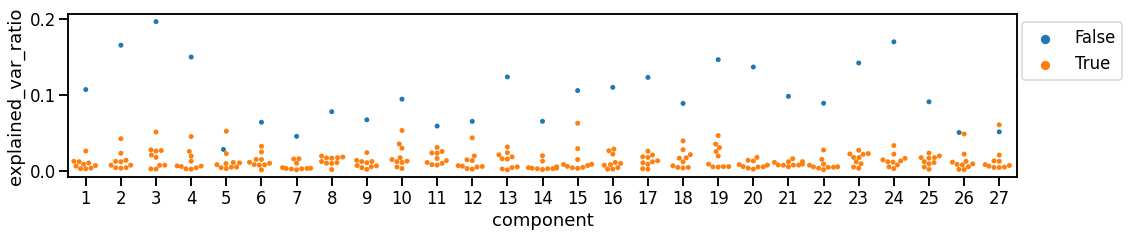

In [229]:
rcParams['figure.figsize']=(17,3)
sb.swarmplot(x='component',y='explained_var_ratio',hue='random',data=explained_var)
plt.legend(bbox_to_anchor=(1.12,1))

C: Some GPs explain overall less var, but for 26&27 probably due to less cells there - see that separate a lot by study. But 5 is probably more random.

### Explained var in each dataset

In [101]:
# Load and summarise data of explained var and also parse all results into shared table
explained_var_all=[]
for dataset in dataset_info.index:
    explained_var=pd.read_table(path_save+dataset+'.tsv')
    evar=explained_var.query('GPs=="GPs" & study==False')['explained_var_ratio'].values
    if evar.shape[0]!=1:
        raise ValueError('More than 1 explained var value')
    dataset_info.at[dataset,'explained_var']=evar[0]
    random_var= explained_var.fillna('NA').query(
        'GPs.str.startswith("GPs_random") & ~GPs.str.contains("component") & study==False',
        engine='python'
        )['explained_var_ratio']
    dataset_info.at[dataset,'explained_var_radom_m']= random_var.mean()
    dataset_info.at[dataset,'explained_var_radom_std']= random_var.std()
    dataset_info['explained_var_n_std']=\
        ((dataset_info['explained_var']-dataset_info['explained_var_radom_m'])/
        dataset_info['explained_var_radom_std'])
    explained_var['component']=explained_var['GPs'].fillna('NA').apply(
        lambda x: np.nan if x =='NA' else 
        ('GPs' if 'component' not in x else x.split('component')[1]))
    explained_var['random']=explained_var['GPs'].str.contains('random')
    explained_var['dataset']=dataset
    explained_var['organism']=dataset_info.at[dataset,'organism']
    explained_var_all.append(explained_var)
explained_var_all=pd.concat(explained_var_all)    

In [102]:
dataset_info

,dataset,organism,technology,n_cells,n_gp_genes,explained_var,explained_var_radom_m,explained_var_radom_std,explained_var_n_std
dataset,,,,,,,,,
mouseAtlas,mouseAtlas,mouse,10X,102143,1659,0.680508,0.230903,0.022948,19.591923
GSE137909,GSE137909,mouse,STRT-seq,1005,1570,0.477245,0.187687,0.021454,13.496686
GSE83146,GSE83146,mouse,FluidigmC1_SMARTer,207,1554,0.315095,0.212668,0.012979,7.891927
GSE83139,GSE83139,human,Fluidigm_SMART-seq,111,1423,0.350042,0.310782,0.005331,7.363838
GSE154126,GSE154126,human,SMART-seq,182,1360,0.265033,0.203880,0.010029,6.097779
GSE101207,GSE101207,human,Drop-seq,9958,1029,0.514281,0.146960,0.069788,5.263360
GSE124742_GSE164875-patch,GSE124742_GSE164875-patch,human,SMART-seq2,496,1461,0.295505,0.145873,0.011535,12.971986
GSE124742_GSE164875-facs,GSE124742_GSE164875-facs,human,SMART-seq2,674,1418,0.320157,0.178559,0.011169,12.678008
GSE86469,GSE86469,human,FluidigmC1_SMARTer,264,1482,0.230156,0.147312,0.005000,16.568801


#### Effect of data characteristic on explained var
How much var is explained with all GPs across studies and how covariates (species, n cells in dataset, n GP genes present in data) affect the overall explained var.

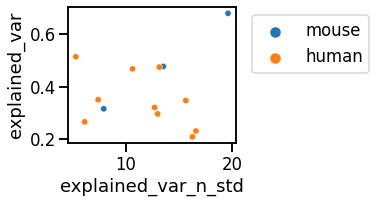

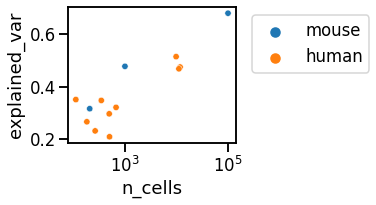

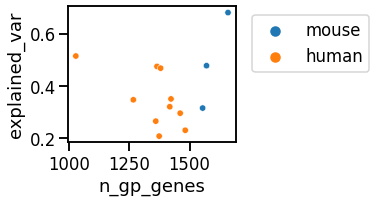

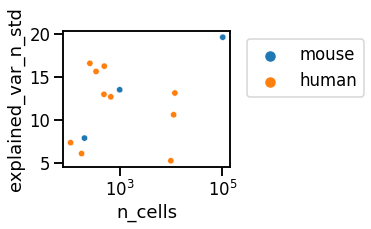

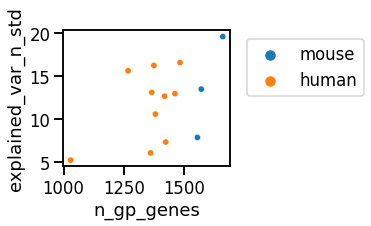

In [419]:
# Plot explained var vs covariates
for y in ['explained_var','explained_var_n_std']:
    for x in ['explained_var_n_std','n_cells','n_gp_genes']:
        if x!=y:
            fig,ax=plt.subplots(figsize=(3,2.5))
            sb.scatterplot(x=x,y=y,hue='organism',data=dataset_info,s=40)
            plt.legend(bbox_to_anchor=(1.05, 1))
            if x=='n_cells':
                plt.xscale('log')

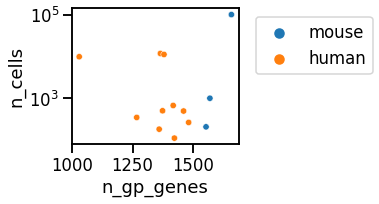

In [420]:
fig,ax=plt.subplots(figsize=(3,2.5))
sb.scatterplot(x='n_gp_genes',y='n_cells',hue='organism',data=dataset_info,s=40)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.yscale('log')

#### Explained var significance
Per-dataset comparison of var explained by GPs and random gene groups

In [23]:
species_palette={'human':'#8a9e59','mouse':'#c97fac'}

In [103]:
# For renaming datasets
rename_ds={
    'GSE124742_GSE164875-patch':'GSE124742_GSE164875_patch',
    'GSE124742_GSE164875-facs':'GSE124742_FACS',
    'sophieHuman':'GSE198623'
}
# rename datasets
explained_var_all.dataset=explained_var_all.dataset.replace(rename_ds)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warn

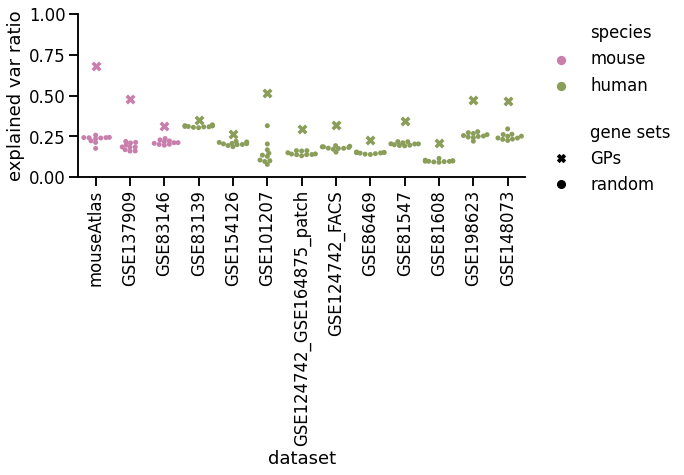

In [104]:
# Plot explained var vs random explained var for each dataset
rcParams['figure.figsize']=(8,3)
sb.swarmplot(x='dataset',y='explained_var_ratio',hue='organism',marker='X',s=10,
            data=explained_var_all.query('component=="GPs" & study==False & random==False'),
            palette=species_palette)
g=sb.swarmplot(x='dataset',y='explained_var_ratio',hue='organism',
            data=explained_var_all.query('component=="GPs" & study==False & random==True'),
            palette=species_palette)
g.get_legend().remove()
g.set_ylim((0,1))
a=plt.xticks(rotation=90)

handles,labels=g.get_legend_handles_labels()
legend_elements=dict()
legend_elements['species']=Line2D([0], [0], markersize=0,lw=0)
legend_elements.update(zip(labels,handles))
legend_elements['\ngene sets']=Line2D([0], [0], markersize=0,lw=0)                                       
legend_elements['GPs']=Line2D([0], [0], marker='X', color='k', 
                          markerfacecolor='k', markersize=8,lw=0)
legend_elements['random']=Line2D([0], [0], marker='o', color='k', 
                          markerfacecolor='k', markersize=8,lw=0)
a=g.legend(handles=legend_elements.values(),labels=legend_elements.keys(), 
          bbox_to_anchor=(1.01,1.03))
# Transparency
g.set(facecolor = (0,0,0,0))
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
a=g.set_ylabel('explained var ratio')
g.get_legend().get_frame().set_alpha(None)
g.get_legend().get_frame().set_facecolor((0, 0, 0, 0))
g.get_legend().get_frame().set_edgecolor((0, 0, 0, 0))
plt.savefig(path_fig+'swarmplot_beta_GPexplainedVar_datasets.png',dpi=300,bbox_inches='tight')

#### Explained var in each dataset by individual GPs

Explained var in each study by individual GPs. How much var is explained and how many stds is this from mean on random gene groups.

In [9]:
# Get explained var for each component in each dataset and compare to random var
explained_component=[]
for (dataset, component),data in explained_var_all.query(
    'study==False & component!="GPs"').groupby(['dataset','component']):
    explained=data[~data.random.astype(bool)]['explained_var_ratio'].values[0]
    explained_random=data[data.random.astype(bool)]['explained_var_ratio']
    explained_n_std=(explained-explained_random.mean())/explained_random.std()
    organism=data.organism.values[0]
    organism_short='mm' if organism =='mouse' else 'hs'
    explained_component.append(
        {'dataset':dataset,'component':component,'organism':organism,
         'org_dataset':organism_short+'_'+dataset,
        'explained_var':explained,'explained_var_n_std':explained_n_std})
explained_component=pd.DataFrame(explained_component)  
# Sort components for plotting
explained_component['component']=pd.Categorical(
    explained_component['component'],
    [str(c) for c in sorted(explained_component['component'].astype(int).unique())],
    True)
explained_component['org_dataset']=pd.Categorical(
    explained_component['org_dataset'],sorted(explained_component['org_dataset'].unique()),True)

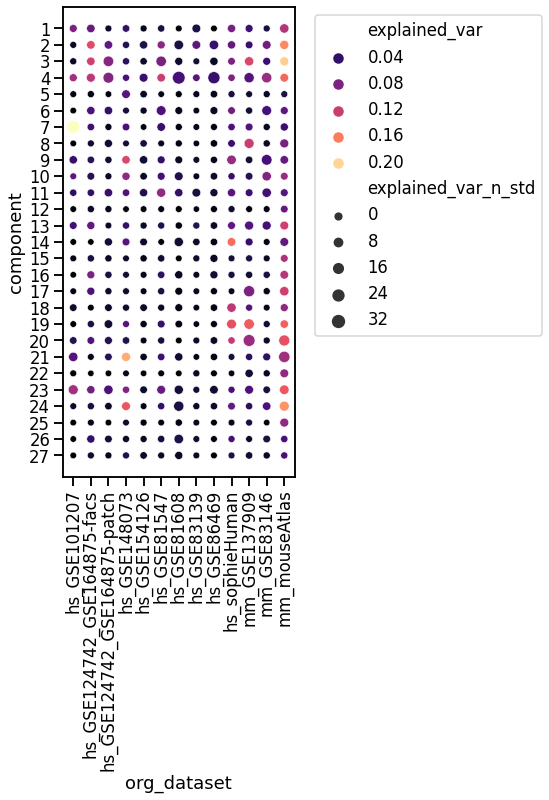

In [423]:
# Explained var by component
rcParams['figure.figsize']=(explained_component.dataset.nunique()*0.32,
                            explained_component.component.nunique()*0.32)
sb.scatterplot(x='org_dataset',y='component',hue='explained_var',size='explained_var_n_std',
               data=explained_component,palette='magma')
plt.legend(bbox_to_anchor=(1.05, 1))
a=plt.xticks(rotation=90)

Contribution of GP components for each dataset, scaled (maxabs) across GPs

In [10]:
# Scale explained components
scaled=pd.crosstab(columns=explained_component['dataset'],index=explained_component['component'],
            values=explained_component['explained_var'],aggfunc='mean')
scaled=pd.DataFrame(maxabs_scale(scaled),index=scaled.index,columns=scaled.columns)

In [21]:
# rename datasets
scaled.rename(rename_ds,axis=1,inplace=True)
dataset_info.rename(rename_ds,axis=0,inplace=True)

In [35]:
# Add T1D and T2D info
dataset_info['diabetes']=None
for ds in dataset_info.index:
    if ds!='mouseAtlas':
        disease=set(pd.read_excel(path_rna+'external_metadata.xlsx',sheet_name=ds)['disease'])
        if 'T1D' in disease and 'T2D' in disease:
            diabetes='T1D and T2D'
        elif 'T1D' in disease :
            diabetes='T1D'
        elif 'T2D' in disease :
            diabetes='T2D'
        else:
            diabetes='none'
    else:
        diabetes='T1D and T2D'
    dataset_info.at[ds,'diabetes']=diabetes

In [90]:
# dataset anno
diabetes_palette={'T1D':'#E04C4C','T2D':'#1E88E5','T1D and T2D':'#E2BF56','none':'#D4D4D4'}
col_colors=pd.concat([
    # Diabetes anno
    pd.Series(scaled.columns,index=scaled.columns,name='diabetes'
         ).map(dataset_info['diabetes'].to_dict()
         ).map(diabetes_palette),
    # Species annotation
    pd.Series(scaled.columns,index=scaled.columns,name='species'
         ).map(dataset_info['organism'].to_dict()
         ).map(species_palette)
],axis=1)

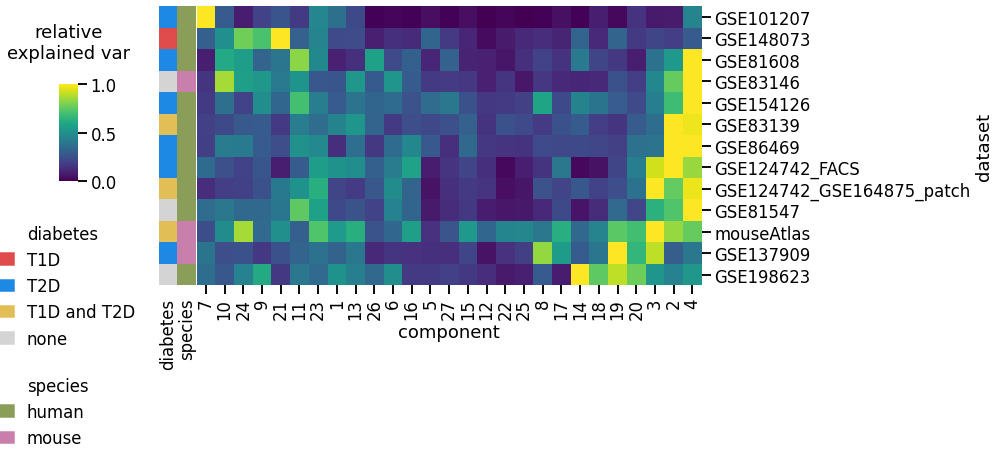

In [105]:
# Plot clustermap of explained var per GP normalised per dataset
# Sizes
w_dend=1.5
w_colors=0.4
nrow=scaled.shape[0]*0.4
ncol=scaled.shape[1]*0.4
w=ncol+w_dend
h=nrow+w_colors*2+w_dend
# Heatmap
g=sb.clustermap(scaled.T,xticklabels=True,yticklabels=True,
              row_colors=col_colors,
              figsize=(h,w),
             colors_ratio=(w_colors/h,w_colors/w),
            dendrogram_ratio=(w_dend/h,w_dend/w),vmin=0,vmax=1,
                cbar_pos=(-0.01,0.43,0.02,0.2),cmap='viridis')
g.ax_cbar.set_title('relative\nexplained var\n')   

#remove dendrogram
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

# Legend for species and diabetes
l=plt.legend(handles=\
             [mpatches.Patch(alpha=0, label='diabetes')]+
             [mpatches.Patch(color=c, label=l) 
                      for l,c in diabetes_palette.items()]+
             [mpatches.Patch(alpha=0, label='\nspecies')]+
             [mpatches.Patch(color=c, label=l) 
                      for l,c in species_palette.items()],
          bbox_to_anchor=(4.8,-0.3))
l.get_frame().set_alpha(0)

# Remove row anno tick
g.ax_row_colors.xaxis.set_ticks_position('none') 

plt.savefig(path_fig+'heatmap_beta_GPexplainedVar_datasets_perGPnorm.png',
            dpi=300,bbox_inches='tight')

C: In most datasets the var is best explained by GPs differing between healthy and T2D